In [ ]:
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot

In [ ]:
import s3fs

s3 = s3fs.core.S3FileSystem(anon=True, client_kwargs={'endpoint_url': 'https://s3.cern.ch'})

In [ ]:
flist = s3.glob('s3://jec-data/test/120*.root')

In [ ]:
from utils.config import DataConfig
from utils.fileio import read_files
from utils.preprocess import build_new_variables, finalize_inputs

def get_data(data_config_file):
    data_config = DataConfig.load(data_config_file)
    table = read_files(flist, data_config.load_branches, s3)
    # define new variables
    build_new_variables(table, data_config.var_funcs)
    # perform input variable standardization, clipping, padding and stacking
    finalize_inputs(table, data_config)
    
    input_data = {key: table[f'_{key}'] for key in data_config.inputs.keys()}
    
    observers = ak.to_pandas({k: table[k] for k in data_config.observers})
    
    return input_data, observers

In [ ]:
pfn_input_data, observers = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_pfn.yaml')
for key in pfn_input_data:
    print(key, pfn_input_data[key].shape)

In [ ]:
particlenet_input_data, _ = get_data('https://raw.githubusercontent.com/deinal/weaver/dev/jet-energy-corrections/data/jec_particle_net.yaml')
for key in particlenet_input_data:
    print(key, particlenet_input_data[key].shape)

In [ ]:
observers.head()

In [ ]:
data_len = observers.shape[0]
batch_size = 100

In [ ]:
def infer(triton_client, inputs):
    triton_inputs = []
    for i, key in enumerate(inputs.keys()):
        triton_inputs.append(httpclient.InferInput(name=key, shape=inputs[key].shape, datatype="FP32"))
        triton_inputs[i].set_data_from_numpy(inputs[key])

    triton_outputs = [httpclient.InferRequestedOutput(name='output')]

    results = triton_client.infer(
        model_name='optimal',
        inputs=triton_inputs,
        outputs=triton_outputs
    )
    return results

### Read data

In [13]:
with s3.open('s3://jec-data/test/120.root') as f:
    jets = uproot.open(f)['Jets']
    jets = jets.arrays(['pt', 'pt_gen', 'ne_eta', 'ne_phi', 'ne_pt', 'ch_eta', 'ch_phi', 'ch_pt', 'sv_eta', 'sv_phi', 'sv_pt'])

### Set up client

In [14]:
import tritonclient.http as httpclient

particlenet_triton_client = httpclient.InferenceServerClient(
    verbose=False,
    url='particle-net-regressor-25a03c.dholmber.svc.cluster.local'
)

### Request predictions

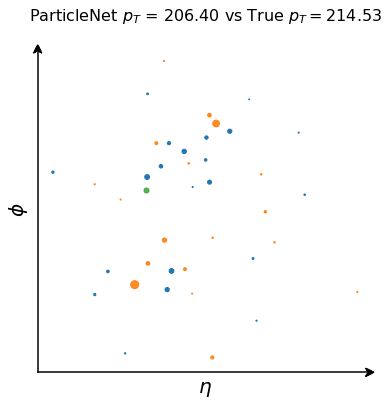

In [ ]:
%%capture --no-display

for i in range(data_len):
    clear_output(wait=True)
    
    jet = jets[i]
    
    inputs = {}
    for key in particlenet_input_data:
        inputs[key] = particlenet_input_data[key][i:i+1]

    prediction = infer(particlenet_triton_client, inputs).as_numpy(name='output').squeeze()
    corrected_pt = np.exp(prediction) * jet.pt
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot()

    al = 7
    arrowprops=dict(
        arrowstyle='fancy',
        mutation_scale=20,
        color='k'
    )
    kwargs = dict(
      xycoords='axes fraction',
      textcoords='offset points',
      arrowprops=arrowprops,
    )

    ax.annotate("", (1.01, -0.0), xytext=(-al, 0.0), **kwargs) # bottom spine arrow
    ax.annotate("", (0.0, 1.01), xytext=(0.0, -al), **kwargs) # left spin arrow

    for side in ['top', 'right']:
        ax.spines[side].set_visible(False)

    ax.yaxis.tick_left()
    ax.xaxis.tick_bottom()

    ax.scatter(jet.ch_eta, jet.ch_phi, s=2*jet.ch_pt, alpha=1.0, label='Charged particles')
    ax.scatter(jet.ne_eta, jet.ne_phi, s=2*jet.ne_pt, alpha=0.9, label='Neutral particles')
    ax.scatter(jet.sv_eta, jet.sv_phi, s=2*jet.sv_pt, alpha=0.8, label='Secondary vertices')
    ax.set_xlabel('$\eta$', fontsize=20)
    ax.set_ylabel('$\phi$', fontsize=20)
    
    ax.set_title(f'ParticleNet $p_T$ = {corrected_pt:.2f} vs True $p_T = {jet.pt_gen:.2f}$\n', fontsize=16)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.pause(1)